##MLP - Feedforward

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the CSV file
df = pd.read_csv('/content/TrainingData.csv')

# Select features and labels
features = df[[' DroneX', ' DroneY', ' FoundTarget', ' TrialNumber']].values
labels = df[[' TargetX', ' TargetY']].values

# Normalize/Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Convert data to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create PyTorch datasets and data loaders
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Custom accuracy function
def custom_accuracy(y_true, y_pred, threshold):
    distances = torch.sqrt(torch.sum((y_true - y_pred) ** 2, dim=1))
    correct = distances < threshold
    return torch.mean(correct.float())

# Early stopping parameters
patience = 50
best_acc = 0.0
counter = 0

# Train the model with early stopping
for epoch in range(50):  # Set a high epoch value
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        total_accuracy = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            accuracy = custom_accuracy(labels, outputs, threshold=150)  # Set your threshold
            total_accuracy += accuracy.item()
        avg_accuracy = total_accuracy / len(val_loader)

        print(f'Epoch {epoch+1}, Val Accuracy: {avg_accuracy:.4f}')

        # Check for improvement
        if avg_accuracy > best_acc:
            best_acc = avg_accuracy
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

# Evaluate on test set
model.eval()
total_accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        accuracy = custom_accuracy(labels, outputs, threshold=150)  # Set your threshold
        total_accuracy += accuracy.item()
test_accuracy = total_accuracy / len(test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1, Val Accuracy: 0.0533
Epoch 2, Val Accuracy: 0.0747
Epoch 3, Val Accuracy: 0.0761
Epoch 4, Val Accuracy: 0.1004
Epoch 5, Val Accuracy: 0.1227
Epoch 6, Val Accuracy: 0.1247
Epoch 7, Val Accuracy: 0.1267
Epoch 8, Val Accuracy: 0.1230
Epoch 9, Val Accuracy: 0.1171
Epoch 10, Val Accuracy: 0.1400
Epoch 11, Val Accuracy: 0.1648
Epoch 12, Val Accuracy: 0.1732
Epoch 13, Val Accuracy: 0.1797
Epoch 14, Val Accuracy: 0.1916
Epoch 15, Val Accuracy: 0.2073
Epoch 16, Val Accuracy: 0.1937
Epoch 17, Val Accuracy: 0.1963
Epoch 18, Val Accuracy: 0.2014
Epoch 19, Val Accuracy: 0.2298
Epoch 20, Val Accuracy: 0.2257
Epoch 21, Val Accuracy: 0.2383
Epoch 22, Val Accuracy: 0.2357
Epoch 23, Val Accuracy: 0.2474
Epoch 24, Val Accuracy: 0.2167
Epoch 25, Val Accuracy: 0.2327
Epoch 26, Val Accuracy: 0.2243
Epoch 27, Val Accuracy: 0.2490
Epoch 28, Val Accuracy: 0.2496
Epoch 29, Val Accuracy: 0.2546
Epoch 30, Val Accuracy: 0.2639
Epoch 31, Val Accuracy: 0.2567
Epoch 32, Val Accuracy: 0.2506
Epoch 33, Val Acc

KeyboardInterrupt: ignored

In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/TrainingData.csv')

# Display the first few rows of the dataframe
print(df.head())

   DroneID   DroneX   DroneY   Faulty   TargetX   TargetY   CanFindTarget  \
0        0      335      665    False       244       695           False   
1        1      230      686    False       244       695           False   
2        2      861      238    False       244       695           False   
3        3     1309      383    False       244       695           False   
4        4      598      376    False       244       695           False   

    FoundTarget   Cycle   TrialNumber  
0         False       0             1  
1         False       0             1  
2         False       0             1  
3         False       0             1  
4         False       0             1  


##LSTM: Good model

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Function to pad sequences
def pad_sequences(sequences, max_length):
    padded_sequences = np.zeros((len(sequences), max_length))
    for i, sequence in enumerate(sequences):
        length = len(sequence)
        padded_sequences[i, :length] = sequence
    return padded_sequences

# Load the dataset
data = pd.read_csv('TrainingData.csv')

# Group data by TrialNumber and Cycle
grouped = data.groupby([' TrialNumber', ' Cycle'])

# Prepare sequences and labels
sequences = []
labels = []

for name, group in grouped:
    sequence = group[[' DroneX', ' DroneY']].values.flatten()  # Flatten the drone positions
    target_position = group[[' TargetX', ' TargetY']].values[0]  # Target position
    sequences.append(sequence)
    labels.append(target_position)

# Find the maximum sequence length
max_length = max(len(seq) for seq in sequences)

# Pad sequences and convert to numpy array
sequences_padded = pad_sequences(sequences, max_length)
labels = np.array(labels)

# Normalization
scaler_sequences = StandardScaler()
sequences_normalized = scaler_sequences.fit_transform(sequences_padded)
scaler_labels = StandardScaler()
labels_normalized = scaler_labels.fit_transform(labels)

# Reshape for LSTM input
sequences_normalized = sequences_normalized.reshape(-1, 1, max_length)  # 1 time step

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences_normalized, labels_normalized, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# LSTM parameters
input_size = max_length
hidden_size = 64
num_layers = 1
output_size = 2

# Initialize the LSTM
lstm = LSTMPredictor(input_size, hidden_size, num_layers, output_size)

# Training parameters
learning_rate = 0.01
num_epochs = 1000

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    lstm.train()
    outputs = lstm(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Custom accuracy function with de-normalization
def custom_accuracy(y_true, y_pred, scaler, threshold):
    y_true_original = scaler.inverse_transform(y_true)
    y_pred_original = scaler.inverse_transform(y_pred)
    correct_predictions = np.sqrt(np.sum((y_true_original - y_pred_original) ** 2, axis=1)) < threshold
    return np.mean(correct_predictions)

# Evaluation with de-normalization
lstm.eval()
original_threshold = 50  # Define a threshold in original units (e.g., meters)
with torch.no_grad():
    predictions = lstm(X_test)
    test_loss = criterion(predictions, y_test)

    # Convert predictions and labels from tensors to numpy arrays for de-normalization
    predictions_np = predictions.numpy()
    y_test_np = y_test.numpy()

    acc = custom_accuracy(y_test_np, predictions_np, scaler_labels, original_threshold)
    print(f'Test Loss: {test_loss.item():.4f}, Custom Accuracy: {acc:.4f}')


Epoch [1/1000], Loss: 1.0109
Epoch [11/1000], Loss: 0.1340
Epoch [21/1000], Loss: 0.0436
Epoch [31/1000], Loss: 0.0213
Epoch [41/1000], Loss: 0.0130
Epoch [51/1000], Loss: 0.0091
Epoch [61/1000], Loss: 0.0070
Epoch [71/1000], Loss: 0.0057
Epoch [81/1000], Loss: 0.0048
Epoch [91/1000], Loss: 0.0041
Epoch [101/1000], Loss: 0.0036
Epoch [111/1000], Loss: 0.0032
Epoch [121/1000], Loss: 0.0029
Epoch [131/1000], Loss: 0.0026
Epoch [141/1000], Loss: 0.0024
Epoch [151/1000], Loss: 0.0022
Epoch [161/1000], Loss: 0.0020
Epoch [171/1000], Loss: 0.0019
Epoch [181/1000], Loss: 0.0017
Epoch [191/1000], Loss: 0.0016
Epoch [201/1000], Loss: 0.0015
Epoch [211/1000], Loss: 0.0014
Epoch [221/1000], Loss: 0.0013
Epoch [231/1000], Loss: 0.0013
Epoch [241/1000], Loss: 0.0012
Epoch [251/1000], Loss: 0.0011
Epoch [261/1000], Loss: 0.0011
Epoch [271/1000], Loss: 0.0010
Epoch [281/1000], Loss: 0.0010
Epoch [291/1000], Loss: 0.0009
Epoch [301/1000], Loss: 0.0009
Epoch [311/1000], Loss: 0.0008
Epoch [321/1000], L

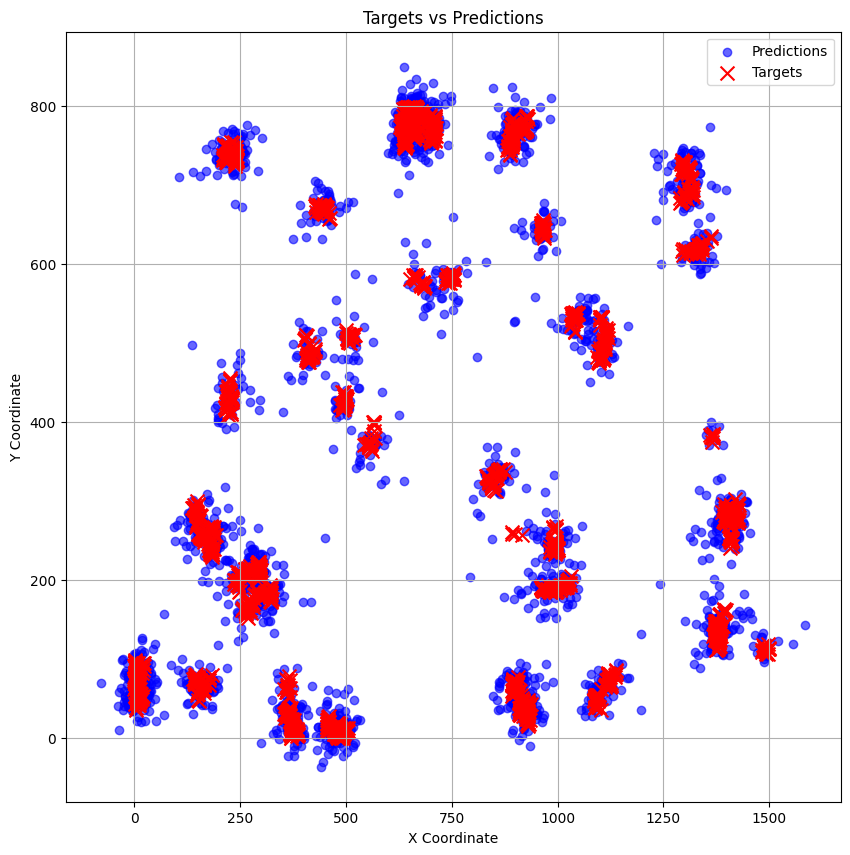

In [40]:
import matplotlib.pyplot as plt

# De-normalize the predictions and actual values
y_test_original = scaler_labels.inverse_transform(y_test_np)
predictions_original = scaler_labels.inverse_transform(predictions_np)

# Extract target and predicted positions
target_x, target_y = y_test_original[:, 0], y_test_original[:, 1]
predicted_x, predicted_y = predictions_original[:, 0], predictions_original[:, 1]

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(predicted_x, predicted_y, color='blue', label='Predictions', alpha=0.6)
plt.scatter(target_x, target_y, color='red', marker='x', s=100, label='Targets')  # Larger size and different marker
plt.title("Targets vs Predictions")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid(True)
plt.show()



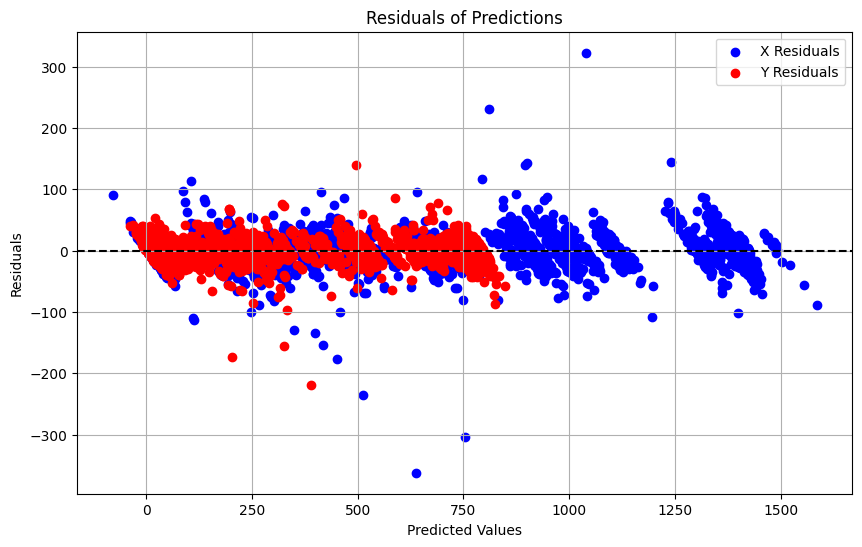

In [41]:
# Calculate residuals
residuals = y_test_original - predictions_original

# Plotting Residuals
plt.figure(figsize=(10, 6))
plt.scatter(predictions_original[:, 0], residuals[:, 0], color='blue', label='X Residuals')
plt.scatter(predictions_original[:, 1], residuals[:, 1], color='red', label='Y Residuals')
plt.title("Residuals of Predictions")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(True)
plt.show()


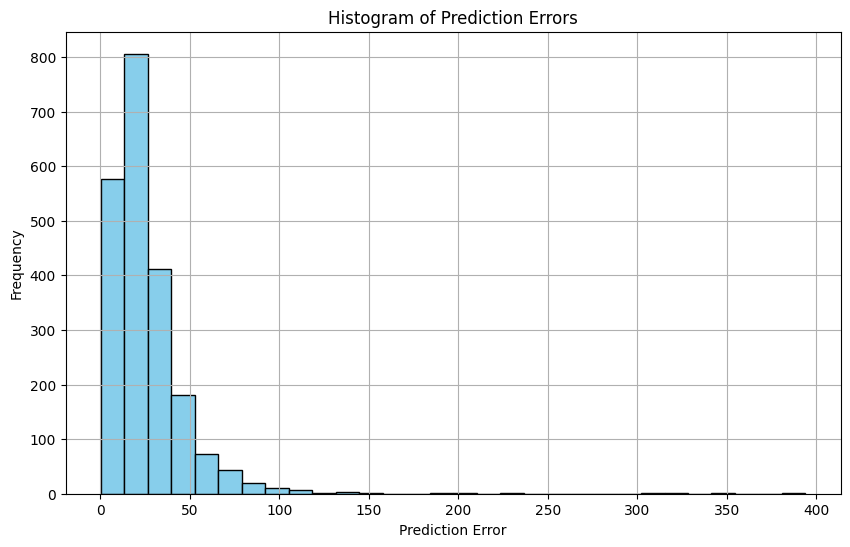

In [42]:
# Calculate errors
errors = np.sqrt(np.sum((y_test_original - predictions_original) ** 2, axis=1))

# Plotting Error Histogram
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Prediction Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [44]:
# Calculate the number of predictions
num_predictions = len(predictions_original)
print(f"Number of Predictions: {num_predictions}")


Number of Predictions: 2140
